<div class="alert alert-block alert-danger">
<b>Check the Kernel you are using:</b> Before we get started, if you are running this on HiPerGator, double check the kernel in use. This is shown in the top right of the window and should look like: <img src="images/kernel.python310.png" alt"Image showing that the notebook is using the Python 3.10 Full kernel" style="float:right">
</div>



*This notebook is based on Chapter 5.11 of the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*


# Clustering


Welcome to today's lecture, where we'll be exploring a fundamental concept in unsupervised machine learning: clustering, with a focus on the k-means algorithm. 

As biologists, you're familiar with the vast diversity and complexity inherent in biological data. From gene expression profiles to ecological surveys, biology is replete with datasets that require not just examination, but also organization and understanding. Clustering algorithms, a cornerstone of unsupervised learning, offer a powerful approach to make sense of such complex data in an unsupervised way. These algorithms aim to identify inherent groupings or clusters in the data, based on similarities among data points. This process is somewhat analogous to the way biologists classify organisms into taxa based on shared characteristics.

K-means clustering, in particular, is a method that partitions data into 'k' distinct clusters. The 'means' in k-means refers to the centroids or the geometric centers of these clusters. The algorithm iteratively assigns each data point to the nearest cluster, while optimizing the positions of the cluster centroids. This algorithm's beauty lies in its simplicity and effectiveness, making it a widely used tool in various fields, including biology. In biological contexts, k-means can be instrumental in grouping similar gene expressions, categorizing types of cells in imaging data, or even in ecological niche partitioning.

As we proceed, we'll explore the mathematical underpinnings of k-means clustering, its implementation. This will not only enhance your analytical toolkit but also provide a fresh lens to view and interpret biological data.

Let's import the necessary libraries and load the data we'll be using for this lecture.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

## K-means clustering: the algorithm

The *k*-means algorithm operates on the principle of partitioning a dataset into a specified number of clusters, each defined by its unique characteristics. This algorithm executes its task based on two key concepts:

 - The center of a cluster, referred to as the 'cluster centroid', is computed as the average of all data points assigned to that cluster.
 - Every data point is associated with the nearest cluster centroid, ensuring minimal distance from each point to its corresponding center.

These principles form the core of the *k*-means model. We will explore the specific mechanics of how the algorithm achieves this clustering in due course. First, let's create a straightforward two-dimensional dataset comprising four separate groups.

In line with the unsupervised nature of this algorithm, our initial exploration will be conducted without utilizing any labels for the data points. This approach underscores the algorithm's ability to identify and group data based purely on the inherent structures within the dataset itself.

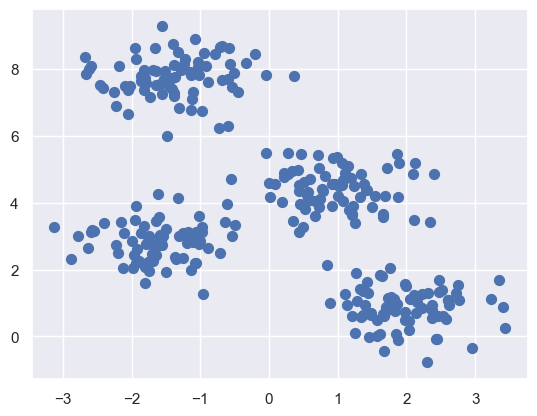

In [2]:
from sklearn.datasets._samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

As you can see, we have four well define clusters.
Let's see how the *k*-means algorithm groups those data points.

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, n_init=15)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Let's plot the cluster assignments as well as the centroids of each cluster.

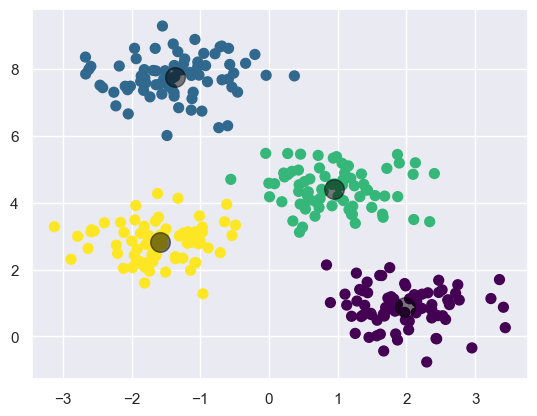

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

The encouraging aspect of the *k*-means algorithm is its ability to categorize points into clusters in a manner quite similar to human intuition, even in straightforward scenarios like this. This naturally raises a question: how does the algorithm efficiently identify these clusters, especially considering the astronomically high number of possible groupings in datasets with numerous data points? An exhaustive search through all possible combinations would be impractical due to its immense computational demand.

Thankfully, an exhaustive search isn't required. The *k*-means algorithm employs a more pragmatic and iterative method known as *expectation–maximization*. This approach smartly navigates through the data, making the task of finding clusters far more computationally manageable and efficient than one might initially assume

## k-Means Algorithm: Expectation–Maximization

Expectation-maximization (E-M) is a crucial algorithm in data science, particularly for the k-means clustering method. The E-M algorithm in k-means simplifies the process of finding clusters in data. It involves the following steps:

1. __Initial Setup - Choosing Cluster Centers__:

 - The process begins by selecting initial positions for the cluster centers. This can be done randomly or based on specific criteria.

2. __Iterative Process__:

 - The algorithm then iterates through two main steps:

   __A. E-Step (Expectation)__:

    - In this step, each data point is assigned to the nearest cluster center. This assignment is based on the distance between the data point and the cluster centers.
   
   __B. M-Step (Maximization)__:

    - Here, the algorithm recalculates the position of each cluster center. The new position is determined by computing the mean of all data points assigned to that cluster.
3. __Convergence__:

 - These two steps (E-step and M-step) are repeated until the positions of the cluster centers stabilize and no longer change significantly. This indicates that the clusters have been effectively identified.
4. __Result and Analysis__:

 - Once the algorithm has converged, the final cluster centers define the grouping of the data. These clusters can then be analyzed to understand the underlying patterns and structures in the data.
The E-M algorithm in k-means is efficient and effective for many practical applications, particularly in organizing and understanding large datasets.

While the body of literature on this algorithm is extensive, the essence is that with each cycle of the E-step and M-step, the estimation of the cluster attributes improves. This is a key strength of the algorithm.

But let's see the expectation-maximation algorithm in action. Let's create a simple implementation of the *k*-means algorithm and then plot cluster assignments at each iteration.


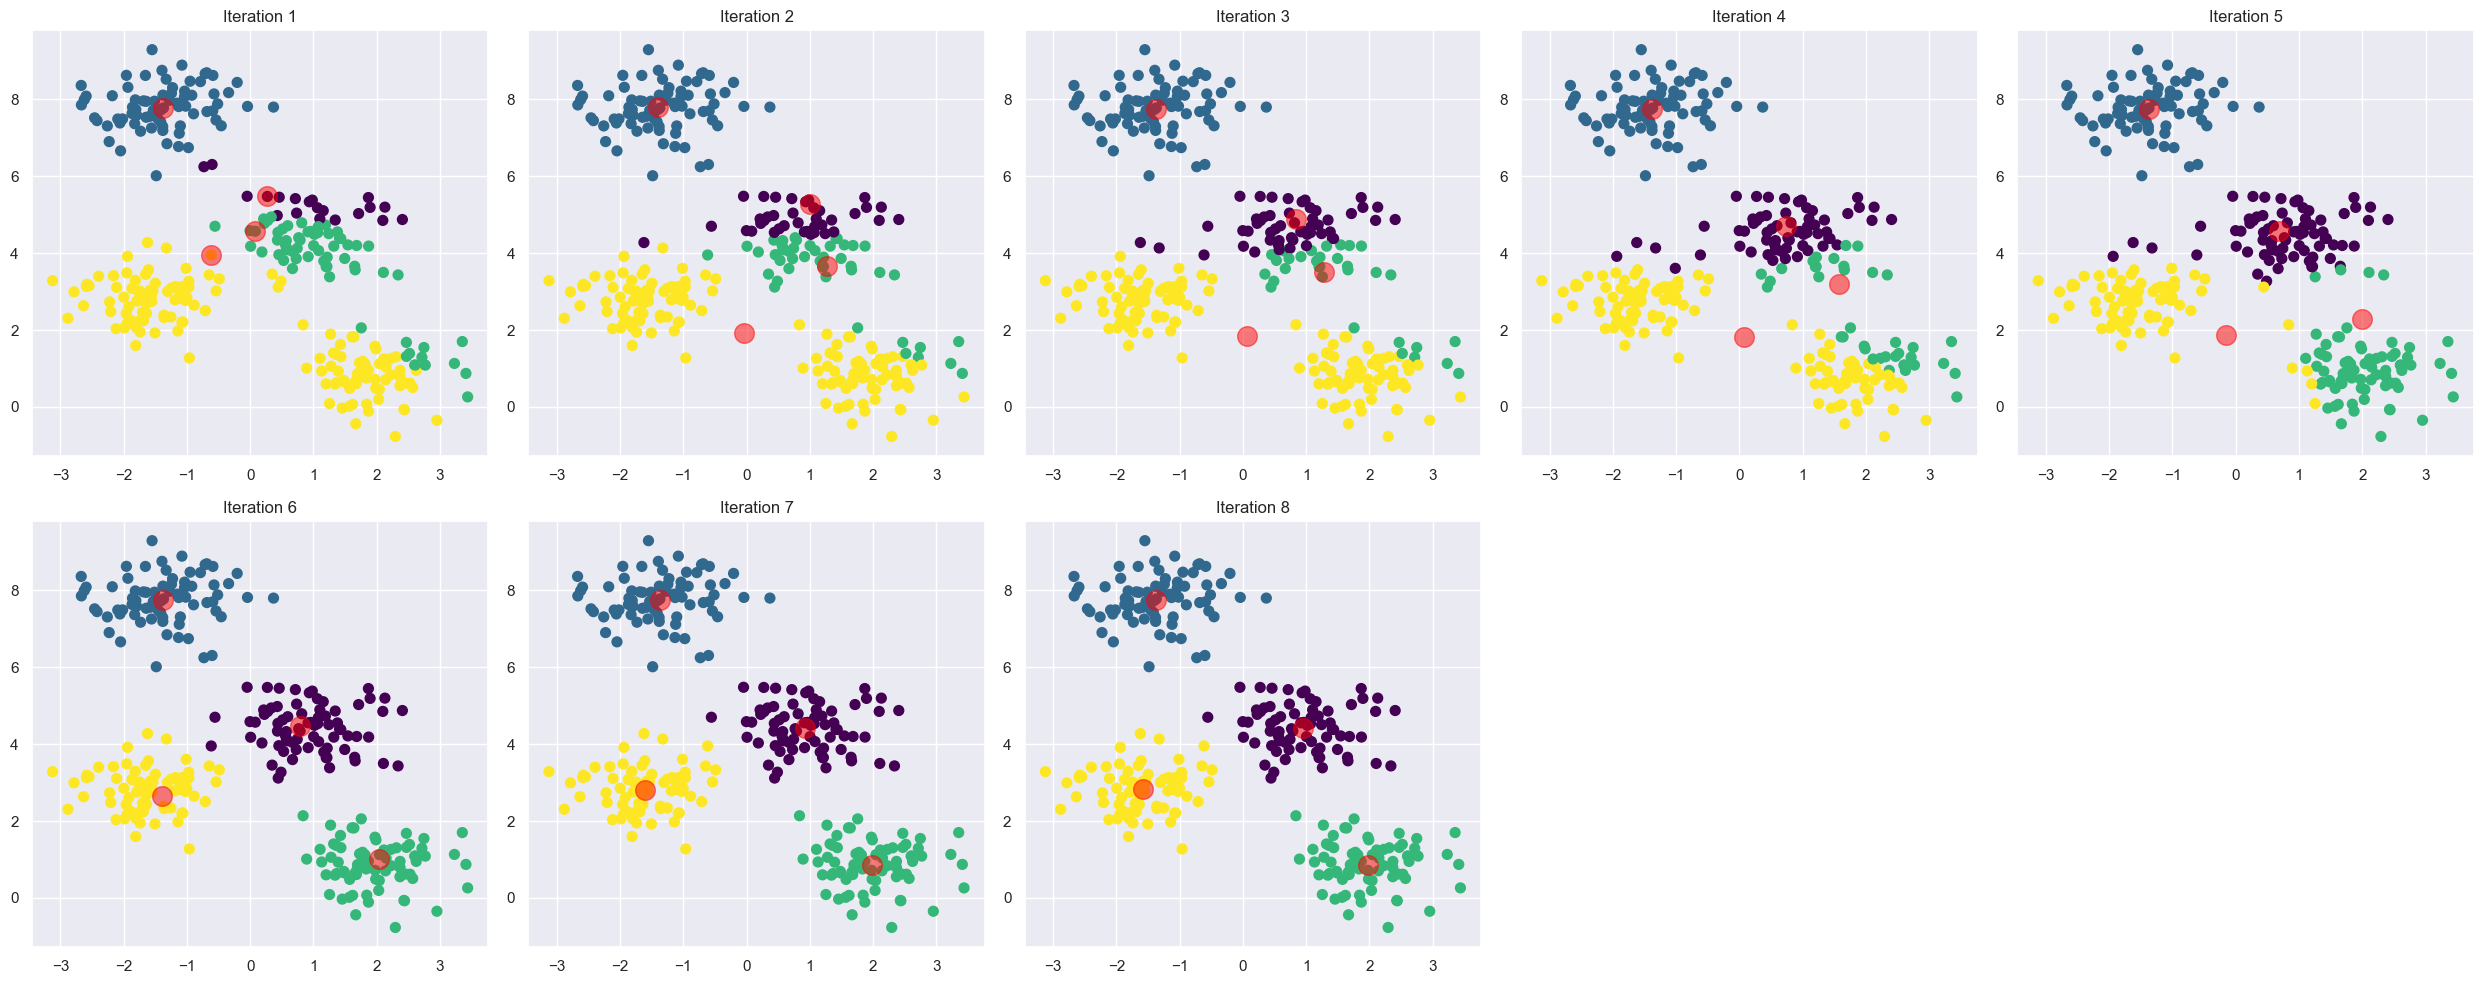

In [5]:
from sklearn.metrics import pairwise_distances_argmin

def store_cluster_data(X, centers, labels, n_clusters, plots_data):
    plots_data.append((X.copy(), centers.copy(), labels.copy()))

def find_clusters(X, n_clusters, rseed=2):
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    plots_data = []
    while True:
        labels = pairwise_distances_argmin(X, centers)
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])

        store_cluster_data(X, centers, labels, n_clusters, plots_data)

        if np.all(centers == new_centers):
            break
        centers = new_centers

    # Determine the number of rows and columns for the subplots
    num_iterations = len(plots_data)
    max_cols = 5
    num_rows = num_iterations // max_cols + (num_iterations % max_cols > 0)
    
    # Create subplots
    fig, axs = plt.subplots(num_rows, max_cols, figsize=(5 * max_cols, 5 * num_rows))
    axs = axs.flatten()  # Flatten in case of a single row

    # Plot each iteration
    for idx, (X_iter, centers_iter, labels_iter) in enumerate(plots_data):
        axs[idx].scatter(X_iter[:, 0], X_iter[:, 1], c=labels_iter, s=50, cmap='viridis')
        axs[idx].scatter(centers_iter[:, 0], centers_iter[:, 1], c='red', s=200, alpha=0.5)
        axs[idx].set_title(f"Iteration {idx+1}")

    # Hide any unused subplots
    for ax in axs[num_iterations:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    return centers, labels

# Example usage with your data 'X'
centers, labels = find_clusters(X, 4)


### Caveats - Local vs Global Minima

Like many iterative algorithms, there are a few issues to be aware of when using the *k*-means algorithm. One of these is the problem of converging to a local minimum.
Although the E-M procedure will navigate the loss landscape and improve the result in each step, there is no assurance that it will lead to the *global* minima. Certain seeds can lead to suboptimal clustering results. 

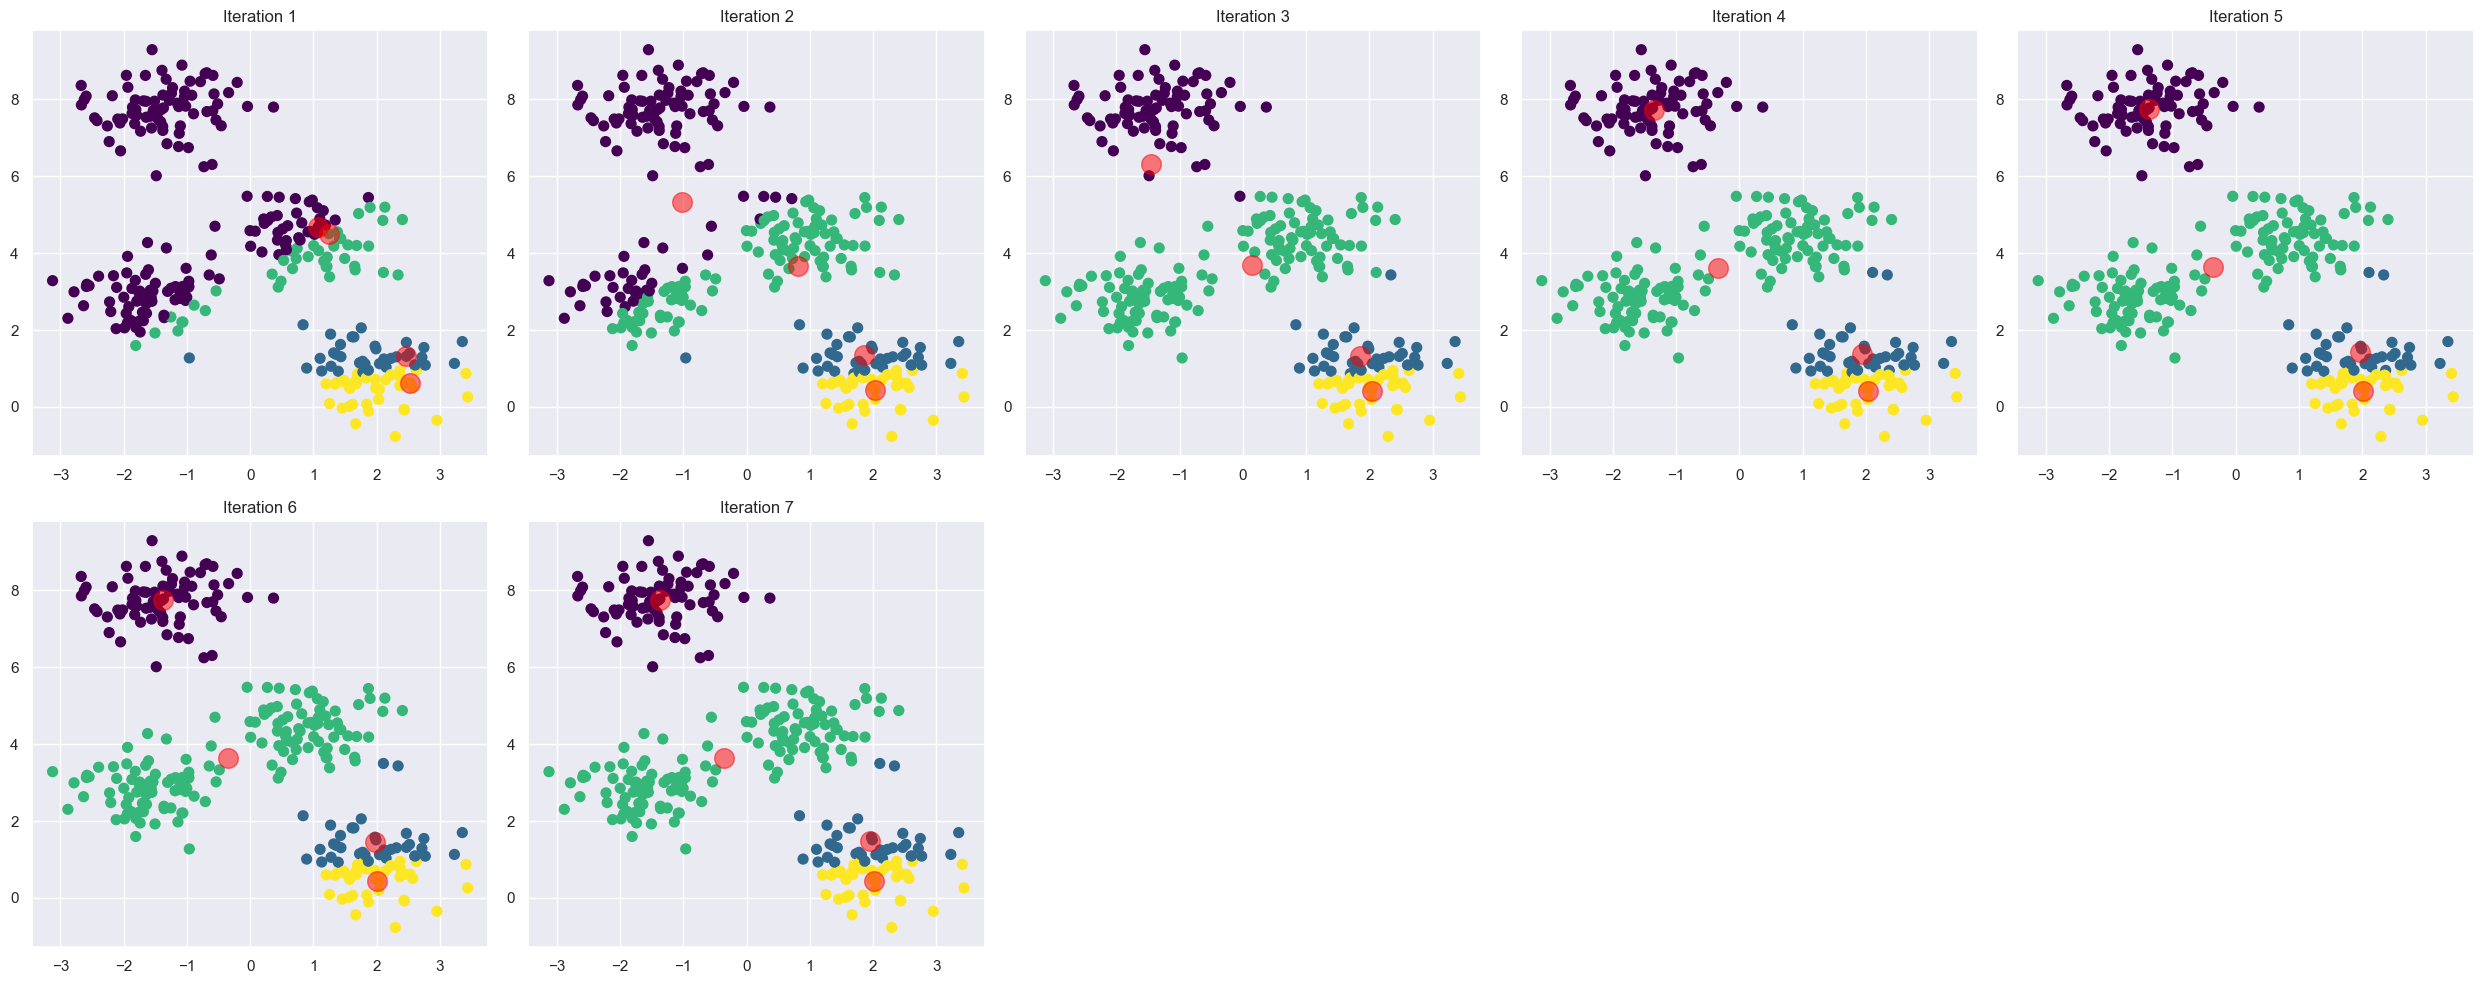

In [6]:
centers, labels = find_clusters(X, 4, rseed=0)


This is a common issue with many iterative algorithms, and the solution is to run the algorithm multiple times with different initializations (``n_init``). For that reason, Scikit-Learn does, by default, set by ``n_init`` parameter to 10.

#### Pre-selecting the Number of Clusters
A notable limitation of the *k*-means algorithm is its requirement for pre-specifying the number of clusters. Unlike some other algorithms, *k*-means doesn't have the capability to determine the optimal number of clusters directly from the data. 
For instance, if we instruct the algorithm to form six clusters, it will follow our direction and identify the best possible configuration of exactly six clusters.


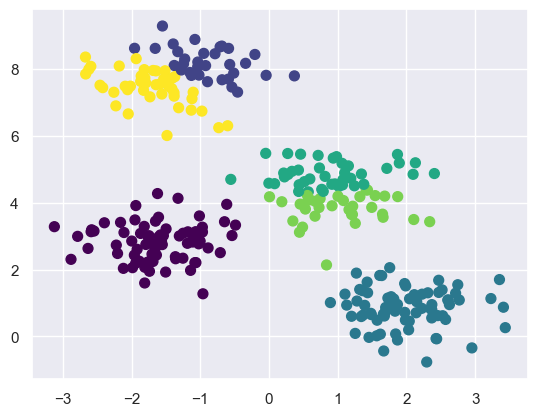

In [7]:
labels = KMeans(6, random_state=0, n_init=15).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

A solution to this problem is known as the *Elbow Method*. It involves calculating the Within-Cluster Sum of Squares (WCSS) for a range of cluster numbers and then plotting these values. The "elbow" of the plot, where the rate of decrease sharply changes, can be a good indicator of the appropriate number of clusters.

Here's a step-by-step guide along with the code:

1. Calculate WCSS for Different Number of Clusters:

 - Iterate over a range of cluster numbers (e.g., 1 to 10).
 - For each number, fit the KMeans model and calculate the WCSS.
 
2. Plot the Results:

 - Plot the number of clusters against the WCSS.
 - Look for the "elbow" where the decrease in WCSS becomes less pronounced.


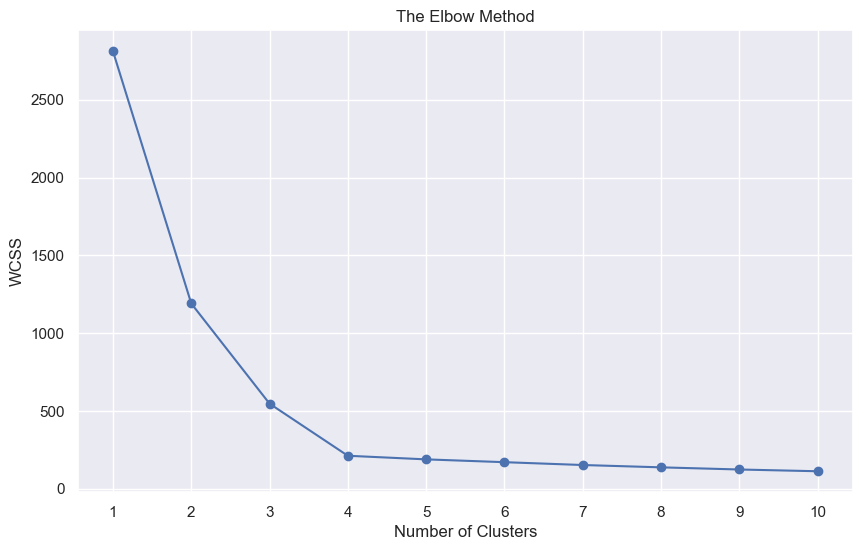

In [9]:
# Range of possible clusters
n_clusters = range(1, 11)

# Empty list to store WCSS
wcss = []

# Calculate WCSS for each number of clusters
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=0, n_init=15).fit(X)
    wcss.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(n_clusters, wcss, 'bo-')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(n_clusters)
plt.show()

Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further here, is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models; see [In Depth: Gaussian Mixture Models](05.12-Gaussian-Mixtures.ipynb)) or which *can* choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the ``sklearn.cluster`` submodule)

#### Linear Nature of Cluster Boundaries in k-means
The intrinsic assumptions of *k*-means, primarily that each point is closer to the centroid of its own cluster than to any other, inherently shape the algorithm's effectiveness. This assumption leads to a significant limitation: k-means tends to create clusters with linear boundaries. As a result, it struggles with complex cluster geometries where linear separations do not suffice.

This limitation becomes particularly evident in scenarios where clusters have non-linear, intricate boundaries. Such situations reveal the inadequacy of *k*-means in capturing the true essence of the data's underlying structure. The following example demonstrates this limitation, showcasing how *k*-means classifies a given dataset with complex geometrical arrangements:


In [10]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

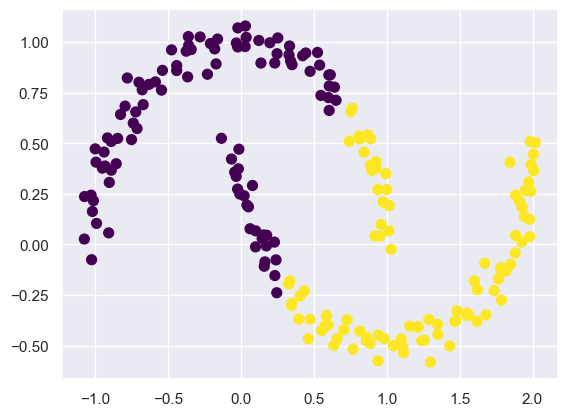

In [11]:
labels = KMeans(2, random_state=0, n_init=15).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### One of many solutions : Spectral Clustering

A kernelized version of *k*-means is available in Scikit-Learn, implemented through the `SpectralClustering` estimator. This method leverages the concept of nearest neighbor graphs to transform the data into a higher-dimensional space. Once in this expanded space, the algorithm applies a traditional *k*-means approach to assign labels to the data points.

This process allows for more complex cluster geometries than standard *k*-means, as it essentially captures the data's manifold structure before applying the clustering algorithm.


c:\Users\arthur.porto\AppData\Local\anaconda3\envs\teach\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


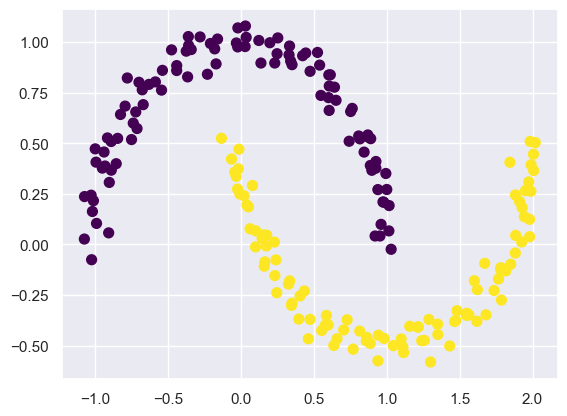

In [12]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### Scalability Challenges with k-means for Large Datasets
The *k*-means algorithm requires accessing every data point in each iteration, which can lead to performance issues as the size of the dataset increases. This naturally raises the question: is it possible to reduce the computational load by not using all the data in every step? Indeed, this concept is the basis for batch-based versions of *k*-means.

One such variant is implemented in Scikit-Learn as `sklearn.cluster.MiniBatchKMeans`. This approach involves using a random subset of data points in each iteration to update the cluster centers, significantly improving efficiency, particularly for large datasets. The usage of `MiniBatchKMeans` is similar to the standard `KMeans`, and we will explore an example of its application later in our discussion.


## Practical Applications of k-means

Despite its limitations, *k*-means clustering can be highly effective in a diverse array of scenarios when used judiciously. Keeping these constraints in mind allows us to leverage the algorithm's strengths to our advantage. Next, we will explore a few examples that illustrate the practical utility of *k*-means in various contexts


### Example 1: Applying k-means to Digit Recognition

Let's begin by applying *k*-means to a simple dataset: the same digits data we explored in previous lectures. Our goal is to use *k*-means to identify similar digits without relying on their original labels. This approach mimics a common scenario in biological data analysis where we seek to derive insights from new datasets lacking pre-existing label information.

We'll start by loading the digits dataset and then applying the `KMeans` clustering algorithm. Remember, the dataset comprises 1,797 samples, each with 64 features. These features represent the brightness levels of each pixel in 8×8 images of the digits:


In [13]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

We then perform clustering as before:

In [14]:
kmeans = KMeans(n_clusters=10, random_state=0, n_init=15)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

The outcome of applying k-means in this context is the formation of 10 clusters within a 64-dimensional space. Interestingly, the centers of these clusters are also 64-dimensional points. 

These centers can be interpreted as the archetypal representation of digits within each cluster. 

To gain a better understanding, let's visualize what these cluster centers look like:


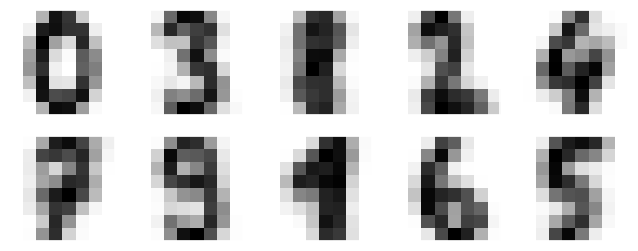

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

It's noteworthy that *KMeans*, even in the absence of label information, manages to identify clusters whose centers resemble recognizable digits, although digits like 1 and 8 might be exceptions.

Since *k*-means operates without prior knowledge of each cluster's identity, the labels from 0 to 9 it assigns can be in a different order. To align these with the true labels, we can match each cluster label identified by *k*-means with the actual labels present in the dataset:


In [16]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now, let's evaluate the accuracy of our unsupervised clustering approach in grouping similar digits within the dataset:


In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

In other words, even without lable information and using purely image intensities, we correctly classify 80% of the input digits!
But what classes are responsible for the remaining 20% of the errors? Let's use the ``confusion_matrix`` tool from Scikit-Learn to find out:

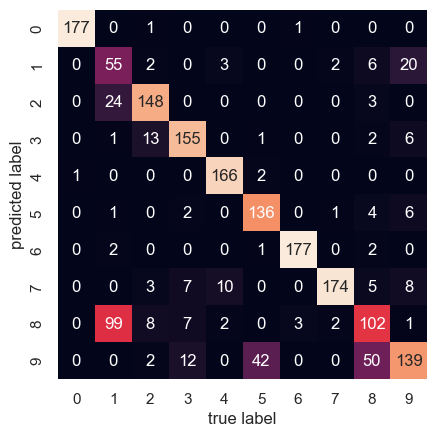

In [18]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

As anticipated from our earlier observation of the cluster centers, the primary area of confusion in the clustering results lies between the digits eight and one. 

This outcome is intriguing as it demonstrates the potential of *k*-means to construct a digit classifier without relying on pre-labeled data.

For an added exploration, let's extend this concept further. We can employ the t-distributed stochastic neighbor embedding (t-SNE) technique, to preprocess the data before applying *k*-means. 

t-SNE is renowned for its effectiveness in nonlinear data embedding, especially in maintaining the integrity of points within clusters. Let's examine the impact of this preprocessing step on the clustering outcome:


In [19]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0, n_init=15)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9415692821368948

That's a 94% classification accuracy *without using the labels*. This example demonstrates the power of unsupervised clustering to create a robust classification model.


### Example 2: Utilizing k-means for Image Color Compression and Segmentation

Clustering, particularly through *k*-means, finds intriguing applications in the realm of image processing, such as color compression within images or image segmentation. Consider a typical image comprising millions of colors. In reality, a significant portion of these colors are often redundant, with many pixels sharing similar or identical hues.

To illustrate, let's examine an image example from the Scikit-Learn `datasets` module. (Note: To work with this example, ensure you have the `Pillow` Python package installed.)


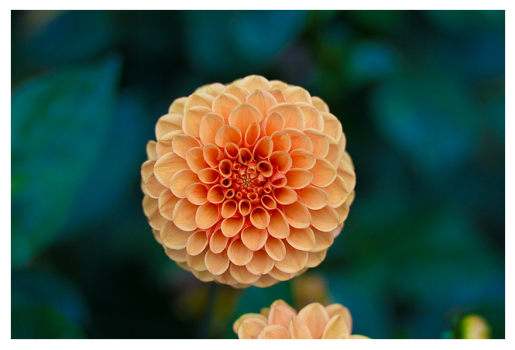

In [20]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
flower = load_sample_image("flower.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(flower);

Note that the image is stored in a three-dimensional array of size ``(height, width, RGB)``, containing red/blue/green channel intensity values as integers from 0 to 255:

In [21]:
flower.shape

(427, 640, 3)

We can conceptualize the set of pixels in the image as a cluster of points within a three-dimensional color space. 

To facilitate this, we need to reshape the data into a `[n_samples x n_features]` format. Additionally, it's essential to rescale the colors so that their values range from 0 to 1:


In [22]:
data = flower / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

And let's plot a 1000-pixel subsample of the image:

In [23]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

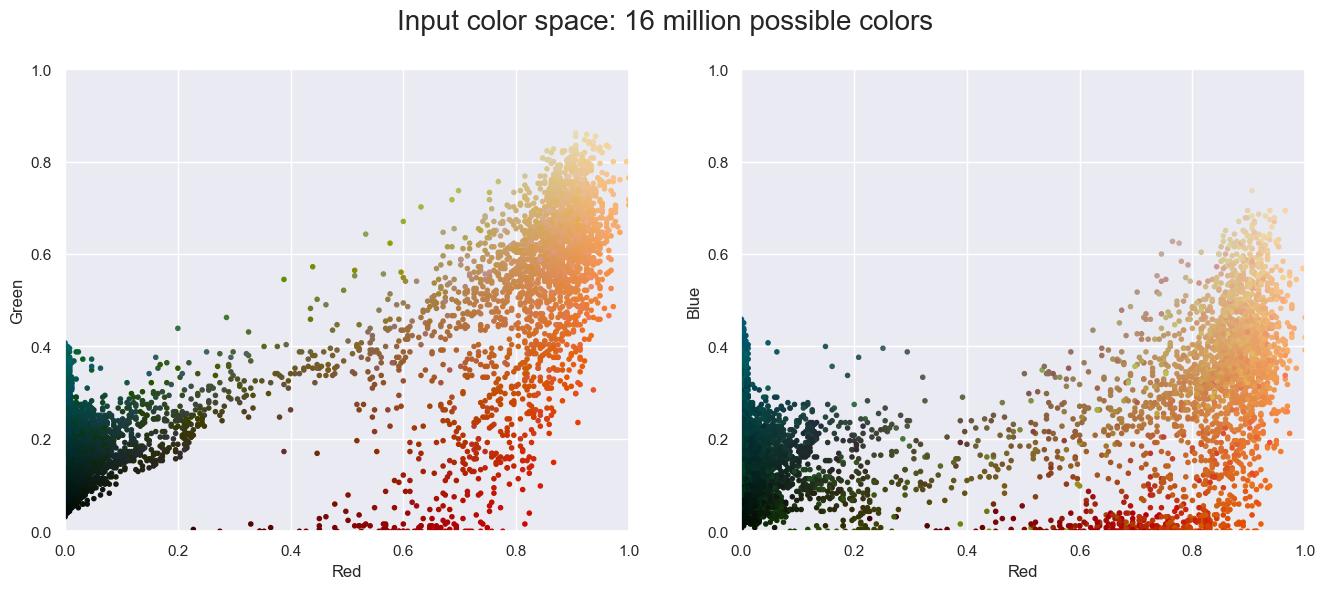

In [24]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now, our objective is to compress the original palette of 16 million colors down to just 64 distinct colors. At the same time, based on these 64 color, we will segment the original image to isolate the flower from the background.

To achieve this, we will apply *k*-means clustering across the pixel space followed by sorting the colors according to how "green" they are (background) and using the "greeness" score for segnmentation. 

Given the extensive size of our dataset, the Mini Batch K-Means algorithm is the preferred choice. 

This variant of *k*-means works on subsets of the data, enabling a significantly faster computation compared to the standard *k*-means algorithm:


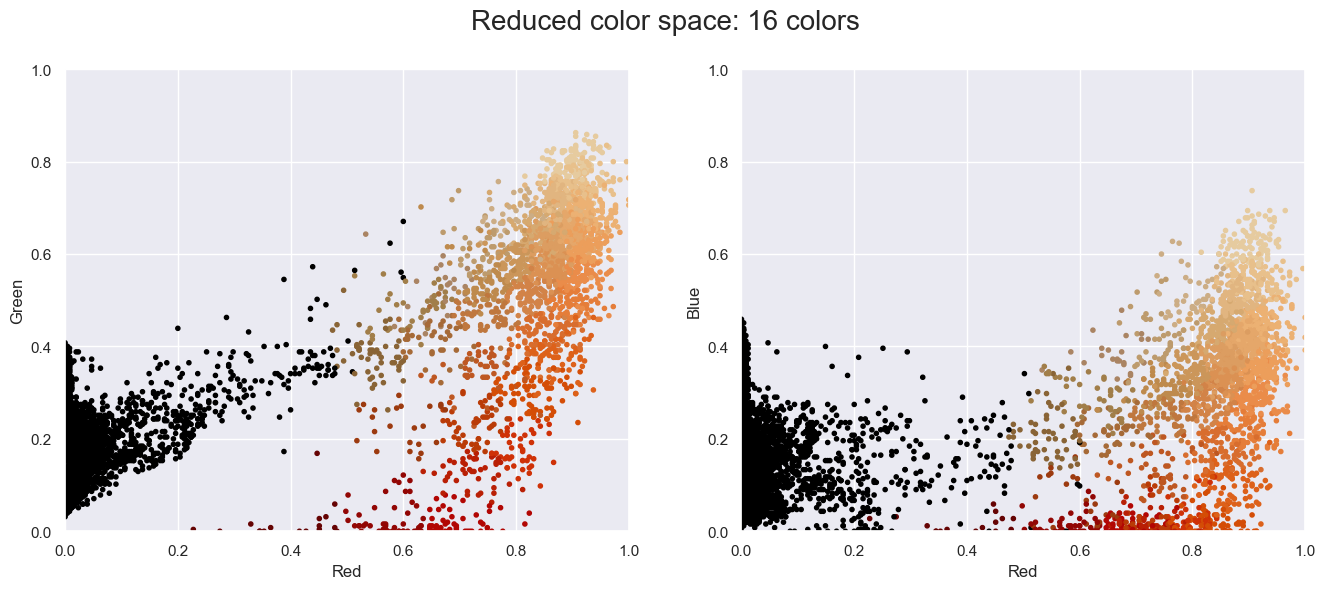

In [25]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(64, n_init=16)
kmeans.fit(data)

# Compute relative greenness score (green component divided by total RGB intensity)
total_intensity = np.sum(kmeans.cluster_centers_, axis=1)
relative_greenness_score = kmeans.cluster_centers_[:, 1] / total_intensity

# Sort clusters by relative greenness and select top N for least greenness
num_least_greenish_colors = 32  # Adjust the number as needed
least_greenish_clusters = np.argsort(relative_greenness_score)[:num_least_greenish_colors]

# Map each data point to the nearest cluster center
labels = kmeans.predict(data)

# Replace colors with least greenish colors if they belong to those clusters
new_colors = np.array([kmeans.cluster_centers_[label] if label in least_greenish_clusters else [0, 0, 0] for label in labels])



plot_pixels(data, colors=new_colors,
            title="Reduced color space: 64 colors")

The result is a segmented and re-colored image, where each pixel is assigned the color of its closest cluster center or to a black color if it belongs to the background cluster.


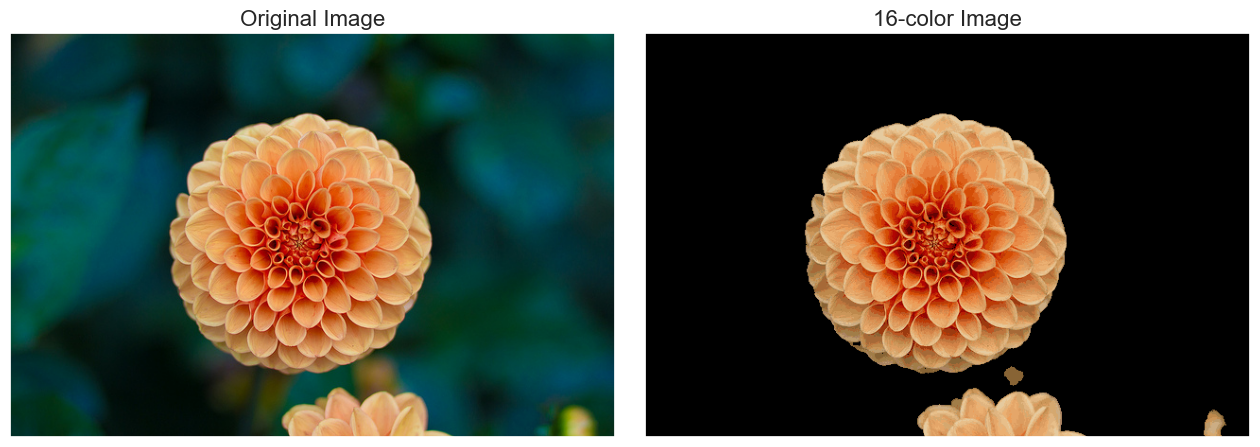

In [26]:
flower_recolored = new_colors.reshape(flower.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(flower)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(flower_recolored)
ax[1].set_title('64-color Image', size=16);

Keep in mind that there are certainly better way to compress information in images and to perform image segmentation.
However, the example in question illustrates the power of unsupervised methods like *k*-means.